1. Подключение библиотек

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

import joblib
import json
import os

In [41]:
df = pd.read_csv("S06-hw-dataset-02.csv")

2.Первичный анализ

In [42]:
print(df.head())
print(df.info())
print(df.describe())

# Распределение таргета
print(df['target'].value_counts(normalize=True))

# Пропуски?
print(df.isnull().sum().any())  # должно быть False

# Типы: все float/int — OK

   id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087   

        f34        f35    x_int_1    x

3.Разделение на X / y и train/test

In [43]:
X = df.drop(columns=['id', 'target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Пояснение:
random_state=42 - воспроизводимость;
stratify=y - сохраняет доли классов в train/test - особенно важно при дисбалансе или при сравнении моделей честно.

4.Baseline’ы

In [44]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

acc_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])

print(f"Dummy: acc={acc_dummy:.3f}, f1={f1_dummy:.3f}, auc={roc_dummy:.3f}")

Dummy: acc=0.738, f1=0.000, auc=0.500


In [45]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])
lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)
y_proba_lr = lr_pipe.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)

lr_params = {
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l2']
}
lr_grid = GridSearchCV(lr_pipe, lr_params, cv=5, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

print(f"LogReg: acc={acc_lr:.3f}, f1={f1_lr:.3f}, auc={roc_lr:.3f}")

LogReg: acc=0.812, f1=0.561, auc=0.798


Интерпретация:
1. DummyClassifier (most_frequent)
Accuracy = 0.738 — модель всегда предсказывает самый частый класс (вероятно, класс 0), и такой подход угадывает правильно ~74% объектов. Это говорит о том, что в данных есть умеренный дисбаланс: один класс действительно преобладает.
F1 = 0.000 — модель никогда не предсказывает положительный класс (1), поэтому precision и recall для него равны нулю → F1 тоже ноль.
ROC-AUC = 0.500 — это эквивалент случайного угадывания: модель не разделяет классы.
2. LogisticRegression
Accuracy = 0.812 — уже лучше dummy на ~7.4 п.п., но accuracy здесь обманчива: даже при росте точности модель может по-прежнему плохо находить редкий класс.
F1 = 0.561 — ключевой показатель! Модель находит часть положительных примеров и делает это с разумным балансом между precision и recall. Это уже осмысленная классификация.
ROC-AUC = 0.798 — хорошее значение: модель уверенно ранжирует объекты, отделяя классы лучше, чем случайно (AUC > 0.75 считается приемлемым, >0.8 — хорошим).

5. Модели недели 6

In [46]:
# a) DecisionTree (с контролем переобучения)
# Простой перебор
dt = DecisionTreeClassifier(random_state=42)
params_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20],
    'ccp_alpha': [0.0, 0.001, 0.01]
}
grid_dt = GridSearchCV(dt, params_dt, cv=5, scoring='roc_auc')
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_

In [47]:
# b) RandomForest
rf = RandomForestClassifier(random_state=42, n_estimators=50)
params_rf = {
    'max_depth': [6, 10],
    'min_samples_leaf': [10],
    'max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(rf, params_rf, cv=5, scoring='roc_auc')
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

In [48]:
# c) GradientBoosting
gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
params_gb = {
    'max_depth': [3, 4],
    'learning_rate': [0.1],
    'subsample': [1.0]
}
grid_gb = GridSearchCV(gb, params_gb, cv=5, scoring='roc_auc')
grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_

6. Оценка всех моделей на test

In [49]:
# 1. Выбираем лучшую модель ТОЛЬКО по CV-score на train
model_scores = {
    'Dummy': -np.inf,
    'LogReg': lr_grid.best_score_,
    'DecisionTree': grid_dt.best_score_,
    'RandomForest': grid_rf.best_score_,
    'GradientBoosting': grid_gb.best_score_
}

best_model_name = max(model_scores, key=lambda k: model_scores[k])
best_model = models[best_model_name]

# 2. ОЦЕНИВАЕМ ВСЕ МОДЕЛИ НА TEST (для отчёта, НЕ для выбора!)
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    results[name] = {
        'accuracy': float(acc),
        'f1': float(f1),
        'roc_auc': float(auc) if auc is not None else None
    }
    
# Сохраняем
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(results, f, indent=4)

7. Диагностические графики

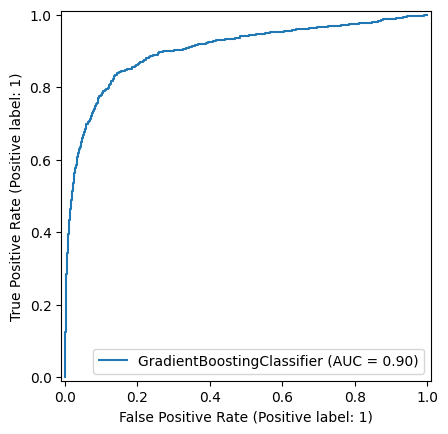

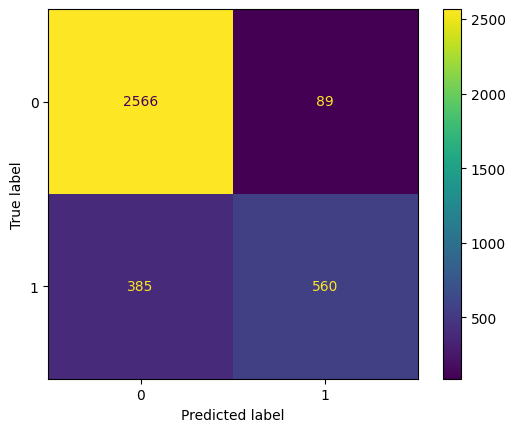

In [50]:
# ROC-кривая для лучшей модели
RocCurveDisplay.from_estimator(best_gb, X_test, y_test)
plt.savefig('artifacts/figures/roc_curve.png')

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_gb, X_test, y_test)
plt.savefig('artifacts/figures/confusion_matrix.png')

8. Permutation Importance (для лучшей модели)

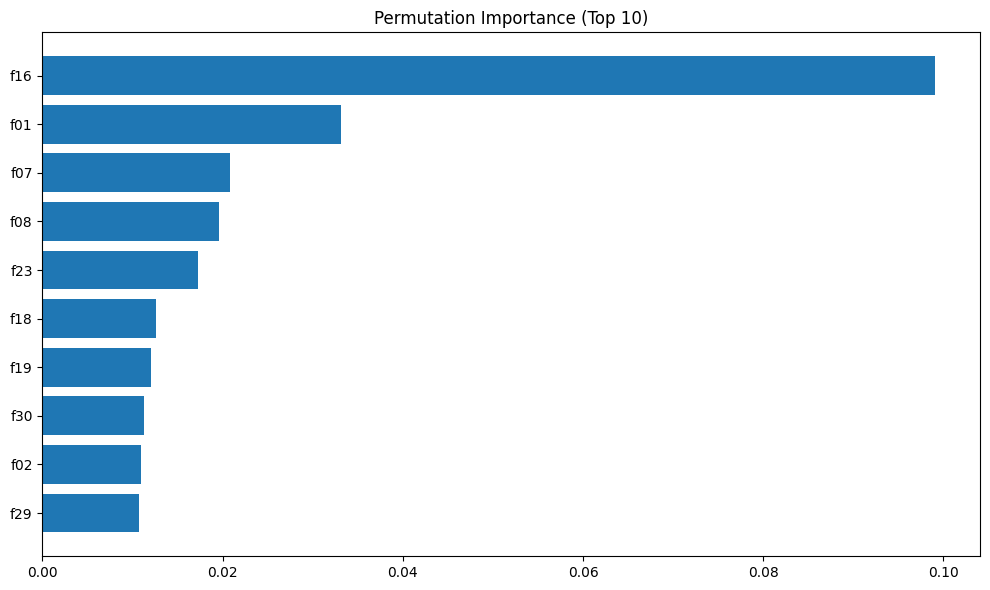

In [51]:
perm_imp = permutation_importance(
    best_gb, X_test, y_test,
    n_repeats=10, random_state=42, scoring='roc_auc'
)

# Top-10
indices = np.argsort(perm_imp.importances_mean)[::-1][:10]
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), perm_imp.importances_mean[indices])
plt.yticks(range(len(indices)), feature_names)
plt.gca().invert_yaxis()
plt.title("Permutation Importance (Top 10)")
plt.tight_layout()
plt.savefig('artifacts/figures/permutation_importance.png')

9. Сохранение артефактов

In [52]:

os.makedirs('artifacts', exist_ok=True)

# 1. metrics_test.json
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(results, f, indent=4)

# 2. search_summaries.json
search_summaries = {
    'DecisionTree': {
        'best_params': grid_dt.best_params_,
        'cv_score': float(grid_dt.best_score_)
    },
    'RandomForest': {
        'best_params': grid_rf.best_params_,
        'cv_score': float(grid_rf.best_score_)
    },
    'GradientBoosting': {
        'best_params': grid_gb.best_params_,
        'cv_score': float(grid_gb.best_score_)
    }
}
with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=4)

# 3. best_model.joblib
best_model_name = max(results.keys(), key=lambda k: results[k]['roc_auc'])
best_model = models[best_model_name]
joblib.dump(best_model, 'artifacts/best_model.joblib')

# 4. best_model_meta.json
meta = {
    'model_name': best_model_name,
    'params': {k: str(v) for k, v in best_model.get_params().items()},
    'test_metrics': results[best_model_name]
}
with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(meta, f, indent=4)

Наблюдения:
Самый важный признак: f16 — его перемешивание снижает AUC больше всего.
Затем следуют: f01, f07, f08, f23 — они также сильно влияют на качество.
Признаки f29, f02, f30 — менее важны, но всё ещё в топ-10.